# Compare to Hydrography
## Overview

1. load GLODAP gridded climatologies for various hydrographic data
2. find closest value to each ForCenS sample point in space
3. plot and compare!


In [66]:
# preamble# Preamble
import numpy as np
import pandas as pd
import xarray as xr
import cartopy as ctpy
import matplotlib.pyplot as plt
import matplotlib as mpl

In [67]:
# load data
T = xr.open_dataset('../data/GLODAPv2.2016b.temperature.nc')
S = xr.open_dataset('../data/GLODAPv2.2016b.salinity.nc')
Si = xr.open_dataset('../data/GLODAPv2.2016b.silicate.nc')
O = xr.open_dataset('../data/GLODAPv2.2016b.oxygen.nc')
CO2 = xr.open_dataset('../data/GLODAPv2.2016b.TCO2.nc')

# load forcens data
df = pd.read_csv('../data/ForCenS_cleaned.csv')
df.head()

,Sample,Sample_ID,Flag,Device,Latitude,Longitude,Water_depth,Ocean,Sample_depth_top,Sample_depth_bottom,...,Globorotalia_menardii_&_Globorotalia_tumida,Globigerinoides_ruber_&_Globigerinoides_white,Turborotalita_humilis_&_Berggrenia_pumilio,Globorotalia_truncatulinoides_dextral_coiling,Globorotalia_truncatulinoides_sinistral_coiling,Trilobatus_sacculifer_w_sac_chamber,Trilobatus_sacculifer_wo_sac_chamber,Turborotalita_quinqueloba_dextral_coiling,Turborotalita_quinqueloba_sinistral_coiling,unidentified
0,A15-559F,CLIMAP_0001,1,Piston,8.9830,51.7330,3797.0,129.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.019074,NaN,NaN,0.032698
1,A152-84,CLIMAP_0002,0,Piston,44.3498,-30.2670,2750.0,7.0,NaN,NaN,...,NaN,NaN,NaN,0.020576,0.014403,0.004115,0.000000,NaN,NaN,0.041152
2,A157-3,CLIMAP_0004,0,Piston,50.9332,-41.7500,4025.0,7.0,NaN,NaN,...,NaN,NaN,NaN,0.007123,0.011396,0.000000,0.001425,NaN,NaN,0.014245
3,A164-13,CLIMAP_0005,1,Piston,35.7167,-67.3333,5103.0,7.0,0.0,0.01,...,NaN,NaN,NaN,0.006637,0.033186,0.015487,0.064159,NaN,NaN,0.035398
4,A164-15,CLIMAP_0006,0,Piston,36.1333,-68.9167,4624.0,7.0,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.029412,0.016043,0.024064,NaN,NaN,0.026738


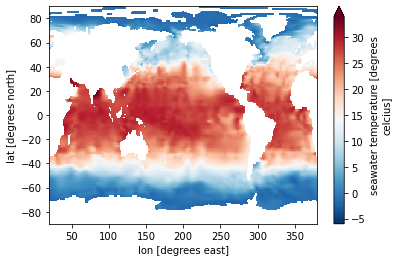

In [68]:
# plot the oceanographic data to check it imported correctly
T['temperature'].sel(depth_surface=0).plot(vmin=-6,vmax=34,cmap='RdBu_r'); # with XArray this only takes one line!!

----
## Find nearest point on GLODAP grid to each ForCenS sample
- using xarray's `method = 'nearest'` approach - <font color='red'> NOTE that this is an inexact nearest-neighbour approach</font>
- define a function `find_point()` which does the indexing
- then iterate through the rows of the ForCenS dataframe finding the nearest values in each
- _there's definitely a more efficient way of doing this, but hey-ho_

In [69]:
def find_point(lat_in,lon_in):
    
    # convert lons to match the GLODAP format (because I'm too lazy to sort the grids out...)
    if 0<lon_in<20:
        lon_in+= 360
        
    if 0>lon_in:
        lon_in = lon_in+360
    
    T_point = T.sel(lon=lon_in, lat=lat_in, method='nearest')
    S_point = S.sel(lon=lon_in, lat=lat_in, method='nearest')
    Si_point = Si.sel(lon=lon_in, lat=lat_in, method='nearest')
    O_point = O.sel(lon=lon_in, lat=lat_in, method='nearest')
    CO2_point = CO2.sel(lon=lon_in, lat=lat_in, method='nearest')
    
    return T_point,S_point,Si_point,O_point,CO2_point

    

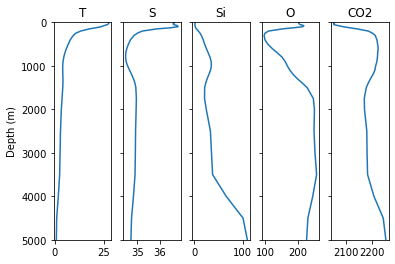

In [70]:
# Test function and plot results
T_point,S_point,Si_point,O_point,CO2_point = find_point(-10,-25)
f,a = plt.subplots(1,5,sharey=True)
a[0].plot(T_point['temperature'],T_point['Depth'])
a[0].set_title('T')
a[1].plot(S_point['salinity'],T_point['Depth'])
a[1].set_title('S')
a[2].plot(Si_point['silicate'],T_point['Depth'])
a[2].set_title('Si')
a[3].plot(O_point['oxygen'],T_point['Depth'])
a[3].set_title('O')
a[4].plot(CO2_point['TCO2'],T_point['Depth'])
a[4].set_title('CO2')

for ax in a:
    ax.invert_yaxis()
    ax.set_ylim(5000,0)
a[0].set_ylabel('Depth (m)');

In [71]:
###---- Iterate through DF Rows and find points ----###
# initialize empty lists
T_surface = []
T_400 = []
T_gradient = []
S_surface = []
S_400 = []
Si_surface = []
Si_400 = []
O_surface = []
O_400 = []
CO2_surface = []
CO2_400 = []

for index, row in df.iterrows(): 
    T_point,S_point,Si_point,O_point,CO2_point = find_point(row['Latitude'],row['Longitude'])
    T_surface.append(T_point['temperature'].sel(depth_surface=0).values.item())
    T_400.append(T_point['temperature'].sel(depth_surface=12).values.item())
    S_surface.append(S_point['salinity'].sel(depth_surface=0).values.item())
    S_400.append(S_point['salinity'].sel(depth_surface=12).values.item())
    Si_surface.append(Si_point['silicate'].sel(depth_surface=0).values.item())
    Si_400.append(Si_point['silicate'].sel(depth_surface=12).values.item())
    O_surface.append(O_point['oxygen'].sel(depth_surface=0).values.item())
    O_400.append(O_point['oxygen'].sel(depth_surface=12).values.item())
    CO2_surface.append(CO2_point['TCO2'].sel(depth_surface=0).values.item())
    CO2_400.append(CO2_point['TCO2'].sel(depth_surface=12).values.item())
    
    if np.isnan(T_400[index]):
        T_gradient.append(np.nan)
    else:
        T_gradient.append(T_surface[index]-T_400[index])
    

df['T_surface'] = pd.Series(T_surface,index=df.index,name='T_surface')
df['T_400'] = pd.Series(T_400,index=df.index,name='T_400')
df['T_gradient'] = pd.Series(T_gradient,index=df.index,name='T_gradient')
df['S_surface'] = pd.Series(S_surface,index=df.index,name='S_surface')
df['S_400'] = pd.Series(S_400,index=df.index,name='S_400')
df['Si_surface'] = pd.Series(Si_surface,index=df.index,name='Si_surface')
df['Si_400'] = pd.Series(Si_400,index=df.index,name='Si_400')
df['O_surface'] = pd.Series(O_surface,index=df.index,name='O_surface')
df['O_400'] = pd.Series(O_400,index=df.index,name='O_400')
df['CO2_surface'] = pd.Series(CO2_surface,index=df.index,name='CO2_surface')
df['CO2_400'] = pd.Series(CO2_400,index=df.index,name='CO2_400')

In [72]:
df.head()

,Sample,Sample_ID,Flag,Device,Latitude,Longitude,Water_depth,Ocean,Sample_depth_top,Sample_depth_bottom,...,T_400,T_gradient,S_surface,S_400,Si_surface,Si_400,O_surface,O_400,CO2_surface,CO2_400
0,A15-559F,CLIMAP_0001,1,Piston,8.9830,51.7330,3797.0,129.0,NaN,NaN,...,11.460279,15.428051,35.573711,35.279728,3.859359,33.907890,212.200546,53.042343,2003.758911,2236.019043
1,A152-84,CLIMAP_0002,0,Piston,44.3498,-30.2670,2750.0,7.0,NaN,NaN,...,12.432641,5.726769,35.890423,35.629200,1.317077,5.221081,236.848587,213.639374,2060.214355,2137.144775
2,A157-3,CLIMAP_0004,0,Piston,50.9332,-41.7500,4025.0,7.0,NaN,NaN,...,6.701771,6.331001,34.827446,34.986717,2.544398,10.893811,263.363251,228.743027,2079.899658,2160.453613
3,A164-13,CLIMAP_0005,1,Piston,35.7167,-67.3333,5103.0,7.0,0.0,0.01,...,18.259352,3.479563,36.471561,36.573139,0.552579,1.080050,218.972961,206.328766,2049.249268,2096.625732
4,A164-15,CLIMAP_0006,0,Piston,36.1333,-68.9167,4624.0,7.0,NaN,NaN,...,18.374033,4.102837,36.541134,36.581097,0.737384,1.228066,212.524887,204.314865,2044.054199,2110.562988


----
## Find relationships - First Pass
- now that there are various oceanographic variables in the dataframe, I'm interested to see which conditions control/influence G. trunc's distribution
- this is a first pass - will make a third notebook for more in-depth statistical analysis (multiple linear regression etc)

<img src="https://www.mikrotax.org/images/pf_cenozoic/Globorotaliidae/Globorotalia/truncatulinoides%20lineage/Globorotalia%20truncatulinoides/K_S%201983%2035-4.JPG" width="300">

_image from Mikrotax.org_

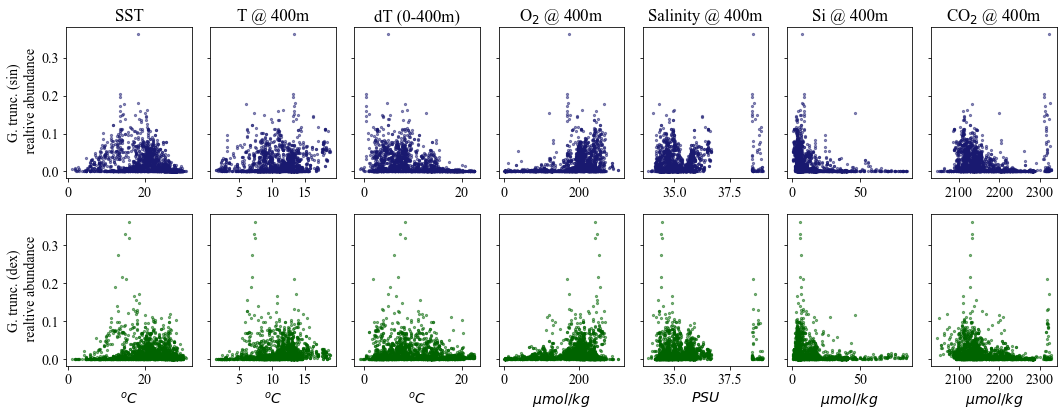

In [91]:
mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = 14


f,axes = plt.subplots(2,7,figsize=(15,6),sharey = True)

y = ['T_surface','T_400','T_gradient','O_400','S_400','Si_400','CO2_400']

ms = 5
col = ['midnightblue','darkgreen']
al=0.5

for i,va in enumerate(y):
    axes[0,i].scatter(df[va],df['Globorotalia_truncatulinoides_sinistral_coiling'],s=ms,c=col[0],alpha=al)
    axes[1,i].scatter(df[va],df['Globorotalia_truncatulinoides_dextral_coiling'],s=ms,c=col[1],alpha=al)
    axes[1,i].set_xlabel(va)

axes[0,0].set_ylabel('G. trunc. (sin)\n realtive abundance')
axes[1,0].set_ylabel('G. trunc. (dex)\n realtive abundance')

axes[0,0].set_title('SST')
axes[0,1].set_title('T @ 400m')
axes[0,2].set_title('dT (0-400m)')
axes[0,3].set_title('O$_2$ @ 400m')
axes[0,4].set_title('Salinity @ 400m')
axes[0,5].set_title('Si @ 400m')
axes[0,6].set_title('CO$_2$ @ 400m')

axes[1,0].set_xlabel('$^oC$')
axes[1,1].set_xlabel('$^oC$')
axes[1,2].set_xlabel('$^oC$')
axes[1,3].set_xlabel('$\mu mol /kg$')
axes[1,4].set_xlabel('$PSU$')
axes[1,5].set_xlabel('$\mu mol /kg$')
axes[1,6].set_xlabel('$\mu mol /kg$')

plt.tight_layout()
plt.savefig('../G_trunc_oceanographic_plots.png',facecolor='w',dpi=300,bbox_inches='tight')

In [86]:
CO2

<xarray.Dataset>
Dimensions:      (depth_surface: 33, lat: 180, lon: 360, snr: 1)
Coordinates:
  * lon          (lon) float64 20.5 21.5 22.5 23.5 ... 376.5 377.5 378.5 379.5
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: depth_surface, snr
Data variables:
    TCO2         (depth_surface, lat, lon) float64 ...
    TCO2_error   (depth_surface, lat, lon) float64 ...
    Input_mean   (depth_surface, lat, lon) float64 ...
    Input_std    (depth_surface, lat, lon) float64 ...
    Input_N      (depth_surface, lat, lon) float64 ...
    TCO2_relerr  (depth_surface, lat, lon) float64 ...
    SnR          (snr) float64 ...
    CL           (snr) float64 ...
    Depth        (depth_surface) float64 ...
Attributes:
    Description:          1 X 1 global mapped field of dissolved inorganic ca...
    Created:              Created by Siv K. Lauvset on 12-May-2016 18:33:56
    Institution name:     University of Bergen
    Contact information:  siv.lauvset@uib.no; are.olsen@uib.no
    Citation:             Cite as: Lauvset, Siv K., Key, Robert M., Olsen, Ar...
    Comment:              Ttza2hhod0eend0s ai2eLlt  a iufucosivonilsr,neer gs...